### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import  RobustScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, SelectPercentile, GenericUnivariateSelect
from sklearn.feature_selection import RFE, RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import f_classif, chi2
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
%matplotlib inline

### Load train and test dataset

In [2]:
AbsenteeismAtWork = pd.read_csv('data/train_data.csv', index_col=0)
AbsenteeismAtWork['Work load Average/day '] = [x.replace(',', '') for x in AbsenteeismAtWork['Work load Average/day ']]
AbsenteeismAtWork['Work load Average/day '] = AbsenteeismAtWork['Work load Average/day '].astype(int)

X_train = AbsenteeismAtWork.drop('Absent', 1)
y_train =  AbsenteeismAtWork['Absent']
X_test = pd.read_csv('data/test_data.csv', index_col=0)
y_test = pd.read_csv('data/sample_submission.csv', index_col=0)



### Funções auxiliares

In [3]:
def robustScaling2(X_train, X_test):
    scaler = RobustScaler()
    scaled_data = scaler.fit_transform( X_train )
    scaled_test = scaler.transform( X_test )
    return scaled_data, scaled_test;

def overSampler(X_train, y_train):
    ros = RandomOverSampler()
    X_balanced, y_train = ros.fit_sample(X_train, y_train)
    X_balanced, y_train = shuffle(X_balanced, y_train)
    return X_balanced, y_train;

def evaluateSelector(featureSelector, selectorName):
    X_train = AbsenteeismAtWork.drop('Absent', 1)
    y_train =  AbsenteeismAtWork['Absent']
    X_test = pd.read_csv('data/test_data.csv', index_col=0)
    y_test = pd.read_csv('data/sample_submission.csv', index_col=0)

    
    # Feature Selection
    X_train_selected, X_test_selected = featureSelector(X_train, y_train, X_test)
    
    # standardizar
    X_train_transformed, X_test_transformed = robustScaling2(X_train_selected, X_test_selected)
    
    
    classifiers = [
        LogisticRegression(),
        SGDClassifier(),
        KNeighborsClassifier(n_neighbors=5),
        SVC(),
        LinearSVC(max_iter=10000),
        GaussianNB(),
        GaussianProcessClassifier(),
        DecisionTreeClassifier(),
        MLPClassifier(max_iter=10000),
        AdaBoostClassifier(),
        RandomForestClassifier(),
    ]
    
    names = [
             "Logistic regression", "SGDClassifier",
             "KNearest Neighbors (5)", 
             "SVM-rbf", "SMV-linear", 
             "Gaussian naive bayes",
             "Gaussian Process", 
             "Decision Tree", 
             "Multi-layer Perceptron", 
             "AdaBoost", "Random Forest"]
    
    # Treinar e avaliar modelos
    for name, clf in zip(names, classifiers):
        clf.fit(X_train_transformed, y_train)
        predicted = clf.predict(X_test_transformed)
        evaluateModel(name + " com " + selectorName, y_test, predicted)
    return;


def evaluateModelBasedSelector(featureSelector, model, name):
    X_train = AbsenteeismAtWork.drop('Absent', 1)
    y_train =  AbsenteeismAtWork['Absent']
    X_test = pd.read_csv('data/test_data.csv', index_col=0)
    y_test = pd.read_csv('data/sample_submission.csv', index_col=0)

    # Feature Selection
    X_train_selected, X_test_selected = featureSelector(X_train, y_train, X_test)
    
    
    # Normalizar, discretizar ou standardizar
    X_train_transformed, X_test_transformed = robustScaling2(X_train_selected, X_test_selected)
    
    # Treinar modelo
    model.fit(X_train_transformed, y_train)
    
    # Prever resultados para test set
    predicted = model.predict(X_test_transformed)
    
    # Avaliar modelo
    evaluateModel(name, y_test, predicted)
    return;

def evaluateModel(name, y_test, predicted):
    print("Accuracy: %0.3f || AUROC %0.3f || (Accuracy, Precision) 0:( %0.3f, %0.3f)  1:( %0.3f, %0.3f) ->" 
              % (accuracy_score(y_test,predicted), roc_auc_score(y_test, predicted),
                recall_score(y_test,predicted,pos_label=0), precision_score(y_test,predicted,pos_label=0),
                recall_score(y_test,predicted,pos_label=1), precision_score(y_test,predicted,pos_label=1)), name)
    return;


def getPickedFeatures(selector, data):
    selected_features_index = selector.get_support(indices=True)
    dropped_features_index = list( set(list(range(0, data.columns.size))) - (set(selected_features_index)))

    selected_features_names = list(data.columns[selected_features_index])
    return selected_features_names;


def getDroppedFeatures(selector, data):
    selected_features_index = selector.get_support(indices=True)
    dropped_features_index = list( set(list(range(0, data.columns.size))) - (set(selected_features_index)))

    dropped_features_names = list(data.columns[dropped_features_index])
    return dropped_features_names;


def printFeatureSelection(selector, data):
    selected_features_index = selector.get_support(indices=True)
    dropped_features_index = list( set(list(range(0, data.columns.size))) - (set(selected_features_index)))

    selected_features_names = zip(selected_features_index,  list(data.columns[selected_features_index]))
    dropped_features_names = zip(dropped_features_index, list(data.columns[dropped_features_index]))

    print("Features mantidas:")
    for cn in selected_features_names:
        print("\t" + str(cn))

    print("Features eliminadas:")
    for cn in dropped_features_names:
        print("\t" + str(cn))
    return;

# Feature Selection

### Funções auxiliares

#### VarianceThreshold

In [4]:
def selectVarianceThreshold(X_train, y_train, X_test):
    varianceThreshold_selector = VarianceThreshold()
    selector = varianceThreshold_selector.fit(X_train, y_train)
    #printFeatureSelection(selector, X_train)
    X_train_selected = varianceThreshold_selector.transform(X_train)
    X_test_selected = varianceThreshold_selector.transform(X_test)
    
    return X_train_selected, X_test_selected;

#### SelectKBest

##### Choosing a K Value

In [11]:
kbest_svc_accuracy = []
kbest_knn_accuracy = []
kbest_logreg_accuracy = []

for i in range(1,19):
    
    X_train_transformed, X_test_transformed = robustScaling2(X_train, X_test)
    X_train_balanced, y_train_balanced = overSampler(X_train_transformed, y_train)
    
    selectKBest = SelectKBest(f_classif, k=i)
    selectKBest.fit(X_train_balanced,y_train_balanced)
    X_train_selected = selectKBest.transform(X_train_balanced)
    X_test_selected = selectKBest.transform(X_test_transformed)
    
    svc = SVC().fit(X_train_selected, y_train_balanced)
    pred_i_svc_kbest = svc.predict(X_test_selected)
    pred_i_svc_kbest_accuracy = accuracy_score(y_test, pred_i_svc_kbest)
    kbest_svc_accuracy.append(pred_i_svc_kbest_accuracy)

    knn = KNeighborsClassifier(n_neighbors=5).fit(X_train_selected, y_train_balanced)
    pred_i_knn_kbest = knn.predict(X_test_selected)
    pred_i_knn_kbest_accuracy = accuracy_score(y_test, pred_i_knn_kbest)
    kbest_knn_accuracy.append(pred_i_knn_kbest_accuracy)

    logreg = LogisticRegression(max_iter=10000).fit(X_train_selected, y_train_balanced)
    pred_i_logreg_kbest = logreg.predict(X_test_selected)
    pred_i_logreg_kbest_accuracy = accuracy_score(y_test, pred_i_logreg_kbest)
    kbest_logreg_accuracy.append(pred_i_logreg_kbest_accuracy)

Text(0, 0.5, 'Accuracy')

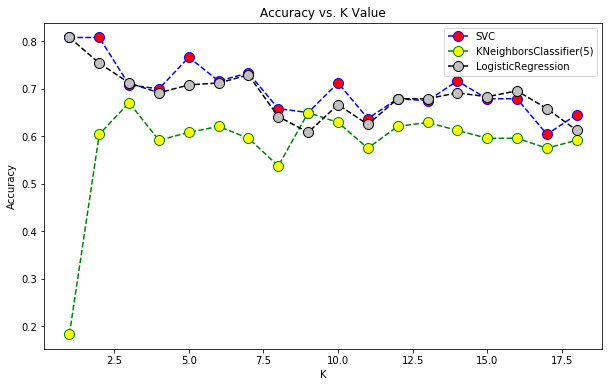

In [12]:
plt.figure(figsize=(10,6))
plt.plot(range(1,19),kbest_svc_accuracy, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10, label='SVC')
plt.plot(range(1,19),kbest_knn_accuracy, color='green', linestyle='dashed', marker='o',
         markerfacecolor='yellow', markersize=10, label='KNeighborsClassifier(5)')
plt.plot(range(1,19),kbest_logreg_accuracy, color='black', linestyle='dashed', marker='o',
         markerfacecolor='silver', markersize=10, label='LogisticRegression')
plt.legend()
plt.title('Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')

In [13]:
def selectKBest_f_classif(X_train, y_train, X_test):
    kbest_selector_f_classif = SelectKBest(f_classif, k=4)
    selector = kbest_selector_f_classif.fit(X_train, y_train)
    #printFeatureSelection(selector, X_train)
    X_train_selected = kbest_selector_f_classif.transform(X_train)
    X_test_selected = kbest_selector_f_classif.transform(X_test)
    
    return X_train_selected, X_test_selected;

def selectKBest_chi2(X_train, y_train, X_test):
    kbest_selector_chi2 = SelectKBest(chi2, k=1)
    selector = kbest_selector_chi2.fit(X_train, y_train)
    #printFeatureSelection(selector, X_train)
    X_train_selected = kbest_selector_chi2.transform(X_train)
    X_test_selected = kbest_selector_chi2.transform(X_test)
    
    return X_train_selected, X_test_selected;

#### SelectPercentile

In [ ]:
def selectPercentile_f_classif(X_train, y_train, X_test):
    percentile_selector_f_classif = SelectPercentile(f_classif, percentile=10)
    selector = percentile_selector_f_classif.fit(X_train, y_train)
    X_train_selected = percentile_selector_f_classif.transform(X_train)
    X_test_selected = percentile_selector_f_classif.transform(X_test)
    
    return X_train_selected, X_test_selected;

def selectPercentile_chi2(X_train, y_train, X_test):
    percentile_selector_chi2 = SelectPercentile(chi2, percentile=10)
    selector = percentile_selector_chi2.fit(X_train, y_train)
    X_train_selected = percentile_selector_chi2.transform(X_train)
    X_test_selected = percentile_selector_chi2.transform(X_test)
    
    return X_train_selected, X_test_selected;

#### GenericUnivariateSelect

In [ ]:
def selectGenericUnivariateSelect(X_train, y_train, X_test):
    gus_selector = GenericUnivariateSelect(f_classif, 'k_best', param=19)
    selector = gus_selector.fit(X_train, y_train)
    X_train_selected = gus_selector.transform(X_train)
    X_test_selected = gus_selector.transform(X_test)
    
    return X_train_selected, X_test_selected;

#### Recursive Feature Elimination

In [ ]:
def rfeLogReg(X_train, y_train, X_test):
    rfe_log_selector = RFE(LogisticRegression(), 12)
    selector = rfe_log_selector.fit(X_train, y_train)
    #printFeatureSelection(selector, X_balanced)
    X_train_selected = rfe_log_selector.transform(X_train)
    X_test_selected = rfe_log_selector.transform(X_test)
    
    return X_train_selected, X_test_selected;


def rfeSVC(X_train, y_train, X_test):
    rfe_svc_selector = RFE(SVC(kernel='linear'), 12)
    selector = rfe_svc_selector.fit(X_train, y_train)
    #printFeatureSelection(selector, X_balanced)
    X_train_selected = rfe_svc_selector.transform(X_train)
    X_test_selected = rfe_svc_selector.transform(X_test)
    
    return X_train_selected, X_test_selected;

#### Recursive Feature Elimination w/ Cross Validation

In [ ]:
def rfeCvLogReg(X_train, y_train, X_test):
    rfecv_log_selector = RFECV(LogisticRegression(), 12)
    selector = rfecv_log_selector.fit(X_train, y_train)
    #printFeatureSelection(selector, X_balanced)
    X_train_selected = rfecv_log_selector.transform(X_train)
    X_test_selected = rfecv_log_selector.transform(X_test)
    
    return X_train_selected, X_test_selected;

def rfeCvSVC(X_train, y_train, X_test):
    rfecv_svc_selector = RFECV(SVC(kernel='linear'), 12)
    selector = rfecv_svc_selector.fit(X_train, y_train)
    #printFeatureSelection(selector, X_balanced)
    X_train_selected = rfecv_svc_selector.transform(X_train)
    X_test_selected = rfecv_svc_selector.transform(X_test)
    
    return X_train_selected, X_test_selected;

#### SelectFromModel

In [ ]:
def sfmLogReg(X_train, y_train, X_test):
    sfm_logReg_selector = SelectFromModel(estimator=LogisticRegression())
    selector = sfm_logReg_selector.fit(X_train, y_train)
    #printFeatureSelection(selector, X_balanced)
    X_train_selected = sfm_logReg_selector.transform(X_train)
    X_test_selected = sfm_logReg_selector.transform(X_test)
    
    return X_train_selected, X_test_selected;

#### SelectFromModel and LassoCV

In [ ]:
def sfmLcvLogReg(X_train, y_train, X_test):
    sfmlcv_logReg_selector = SelectFromModel(LassoCV(),threshold=0.25)
    selector = sfmlcv_logReg_selector.fit(X_train, y_train)
    #printFeatureSelection(selector, X_balanced)
    X_train_selected = sfmlcv_logReg_selector.transform(X_train)
    X_test_selected = sfmlcv_logReg_selector.transform(X_test)
    
    return X_train_selected, X_test_selected;

#### L1-based

In [ ]:
def sfmL1(X_train, y_train, X_test):
    lsvc_selector = LinearSVC(C=0.01, penalty="l1", dual=False)
    selector = lsvc_selector.fit(X_train, y_train)
    l1_selector = SelectFromModel(lsvc_selector, prefit=True)
    #printFeatureSelection(selector, X_balanced)
    X_train_selected = l1_selector.transform(X_train)
    X_test_selected = l1_selector.transform(X_test)
    
    return X_train_selected, X_test_selected;

#### Tree-based

In [ ]:
def sfmTree(X_train, y_train, X_test):
    tree_selector = ExtraTreesClassifier(n_estimators=50)
    selector = tree_selector.fit(X_train, y_train)
    sfm_Tree_selector = SelectFromModel(tree_selector, prefit=True)
    #printFeatureSelection(selector, X_balanced)
    X_train_selected = sfm_Tree_selector.transform(X_train)
    X_test_selected = sfm_Tree_selector.transform(X_test)
    
    return X_train_selected, X_test_selected;

#  Evaluate different models

### Creating and Training the Models

In [ ]:
# Removing features with low variance

evaluateSelector(selectVarianceThreshold, "VarianceThreshold")

In [ ]:
# Univariate feature selection
print("Com f_classif\n\n")
evaluateSelector(selectKBest_f_classif, "Select k best f_classif")

print("Com qui2\n\n")
evaluateSelector(selectKBest_chi2, "Select k best qui2")

In [ ]:
print("Com f_classif\n\n")
evaluateSelector(selectPercentile_f_classif, "Select Percentile")



In [ ]:
evaluateSelector(selectGenericUnivariateSelect, "Generic univariate select")

In [ ]:
# Recursive feature elimination

evaluateModelBasedSelector( rfeLogReg,  LogisticRegression(), "Log Reg w/ RFE LogReg")
evaluateModelBasedSelector( rfeCvLogReg, LogisticRegression(), "Log Reg w/ RFE Cross Validation LogReg")

evaluateModelBasedSelector( rfeSVC, SVC(kernel='linear'), "SVC Linear w/ RFE SVC")
evaluateModelBasedSelector( rfeCvSVC, SVC(kernel='linear'), "SVC Linear w/ RFE Cross Validation SVC")

# Feature selection using SelectFromModel


evaluateModelBasedSelector( sfmLcvLogReg, LogisticRegression(), "Log Reg w/ SelectFromModel and LassoCV")

#evaluateModelBasedSelector( sfmL1, SVC(kernel='linear'), "SVC Linear w/ SelectFromModel L1")

evaluateModelBasedSelector( sfmTree, SVC(kernel='linear'), "SVC Linear w/ SelectFromModel Tree")